Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [75]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [76]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [77]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [78]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### Logistic classification

In [79]:
def multilayer_perceptron_0h(x, weights, biases):
    # Output layer with linear activation
    out_layer = tf.matmul(x, weights['out']) + biases['out']
    return out_layer

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'out': tf.Variable(tf.random_normal([image_size * image_size, num_labels]))
  }
  biases = {
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
 
  # Training computation.
  logits = multilayer_perceptron_0h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_0h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_0h(tf_test_dataset, weights, biases))

In [80]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 15.240114
Minibatch accuracy: 18.0%
Validation accuracy: 16.5%
Minibatch loss at step 500: 1.356315
Minibatch accuracy: 78.1%
Validation accuracy: 74.4%
Minibatch loss at step 1000: 1.592662
Minibatch accuracy: 77.3%
Validation accuracy: 75.3%
Minibatch loss at step 1500: 0.755199
Minibatch accuracy: 79.7%
Validation accuracy: 75.9%
Minibatch loss at step 2000: 0.919732
Minibatch accuracy: 84.4%
Validation accuracy: 76.9%
Minibatch loss at step 2500: 1.108351
Minibatch accuracy: 78.9%
Validation accuracy: 77.5%
Minibatch loss at step 3000: 1.068652
Minibatch accuracy: 78.1%
Validation accuracy: 77.8%
Test accuracy: 85.3%


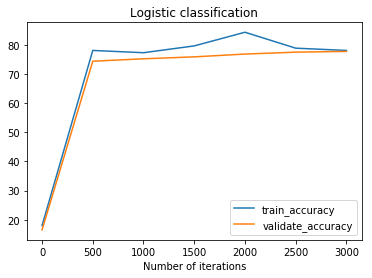

In [81]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('Logistic classification')
plt.show()

### Logistic Classification with L2 regularization

In [90]:
beta_reg = 0.001
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'out': tf.Variable(tf.random_normal([image_size * image_size, num_labels]))
  }
  biases = {
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
 
  # Training computation.
  logits = multilayer_perceptron_0h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) +
    beta_reg*tf.nn.l2_loss(weights['out'])
#   + beta_reg*tf.nn.l2_loss(biases['out'])
  )  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_0h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_0h(tf_test_dataset, weights, biases))

In [91]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 23.325939
Minibatch accuracy: 10.9%
Validation accuracy: 10.5%
Minibatch loss at step 500: 3.144153
Minibatch accuracy: 78.9%
Validation accuracy: 75.6%
Minibatch loss at step 1000: 2.097727
Minibatch accuracy: 77.3%
Validation accuracy: 77.8%
Minibatch loss at step 1500: 1.142889
Minibatch accuracy: 85.2%
Validation accuracy: 79.3%
Minibatch loss at step 2000: 0.873692
Minibatch accuracy: 85.9%
Validation accuracy: 80.2%
Minibatch loss at step 2500: 0.884847
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.802687
Minibatch accuracy: 82.0%
Validation accuracy: 81.7%
Test accuracy: 88.8%


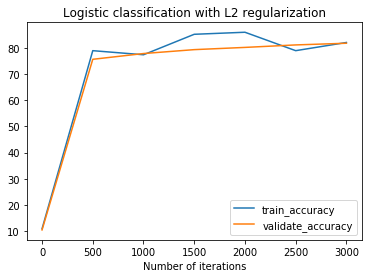

In [92]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('Logistic classification with L2 regularization')
plt.show()

By adding L2 regularization on Logistic Classification, the test accuracy increases from 85.3% to 88.8%

### 1-layer NN

In [85]:
def multilayer_perceptron_1h(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
 
    # Output layer with linear activation
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'out': tf.Variable(tf.random_normal([n_hidden_1, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_1h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_test_dataset, weights, biases))

In [86]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 457.620483
Minibatch accuracy: 8.6%
Validation accuracy: 31.2%
Minibatch loss at step 500: 18.666328
Minibatch accuracy: 82.8%
Validation accuracy: 80.1%
Minibatch loss at step 1000: 11.969043
Minibatch accuracy: 79.7%
Validation accuracy: 79.9%
Minibatch loss at step 1500: 7.894631
Minibatch accuracy: 88.3%
Validation accuracy: 79.9%
Minibatch loss at step 2000: 3.664303
Minibatch accuracy: 86.7%
Validation accuracy: 82.4%
Minibatch loss at step 2500: 3.447689
Minibatch accuracy: 84.4%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 2.341003
Minibatch accuracy: 85.9%
Validation accuracy: 82.5%
Test accuracy: 89.4%


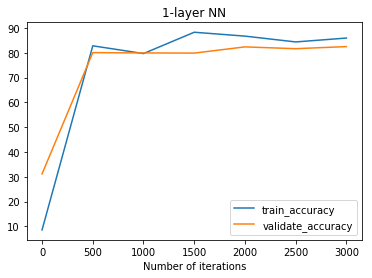

In [87]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('1-layer NN')
plt.show()

### 1-layer NN with L2 regularization

In [93]:
beta_reg = 0.001
batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'out': tf.Variable(tf.random_normal([n_hidden_1, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_1h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
    beta_reg *tf.nn.l2_loss(weights['out']) +
    beta_reg *tf.nn.l2_loss(weights['h1']))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_test_dataset, weights, biases))

In [94]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 885.560791
Minibatch accuracy: 5.5%
Validation accuracy: 31.6%
Minibatch loss at step 500: 255.710663
Minibatch accuracy: 81.2%
Validation accuracy: 80.5%
Minibatch loss at step 1000: 148.559753
Minibatch accuracy: 82.0%
Validation accuracy: 81.8%
Minibatch loss at step 1500: 88.556610
Minibatch accuracy: 89.1%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 53.372452
Minibatch accuracy: 89.1%
Validation accuracy: 83.9%
Minibatch loss at step 2500: 32.507118
Minibatch accuracy: 84.4%
Validation accuracy: 85.2%
Minibatch loss at step 3000: 19.891727
Minibatch accuracy: 85.9%
Validation accuracy: 86.3%
Test accuracy: 92.8%


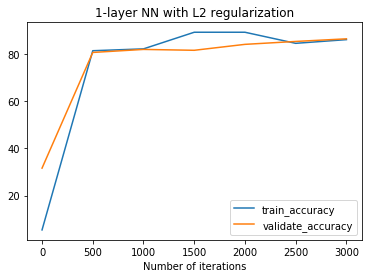

In [95]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('1-layer NN with L2 regularization')
plt.show()

By adding L2 regularization on 1-layer NN, the test accuracy increases from 89.4% to 92.8%.
This is my first model with accuracy over 90%.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [99]:
batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'out': tf.Variable(tf.random_normal([n_hidden_1, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_1h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_test_dataset, weights, biases))

In [102]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = step%num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 20 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 402.043793
Minibatch accuracy: 10.2%
Validation accuracy: 36.3%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 61.1%
Test accuracy: 66.7%


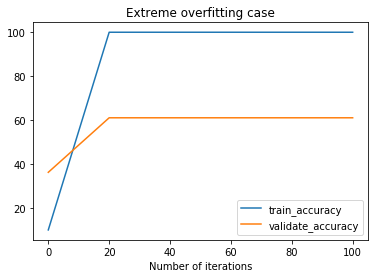

In [103]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('Extreme overfitting case')
plt.show()

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [104]:
def multilayer_perceptron_1h_dropout(x, weights, biases,drop_out):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1_drop = tf.nn.dropout(layer_1,drop_out)
 
    # Output layer with linear activation
    out_layer = tf.matmul(layer_1_drop, weights['out']) + biases['out']
    return out_layer

batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features
drop_out = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'out': tf.Variable(tf.random_normal([n_hidden_1, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_1h_dropout(tf_train_dataset, weights, biases,drop_out)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_1h(tf_test_dataset, weights, biases))

In [105]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = step%num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 20 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 640.470337
Minibatch accuracy: 16.4%
Validation accuracy: 20.6%
Minibatch loss at step 20: 0.592288
Minibatch accuracy: 99.2%
Validation accuracy: 68.1%
Minibatch loss at step 40: 0.242611
Minibatch accuracy: 99.2%
Validation accuracy: 69.9%
Minibatch loss at step 60: 6.150716
Minibatch accuracy: 98.4%
Validation accuracy: 69.8%
Minibatch loss at step 80: 1.738067
Minibatch accuracy: 99.2%
Validation accuracy: 69.8%
Minibatch loss at step 100: 0.000302
Minibatch accuracy: 100.0%
Validation accuracy: 69.6%
Test accuracy: 76.5%


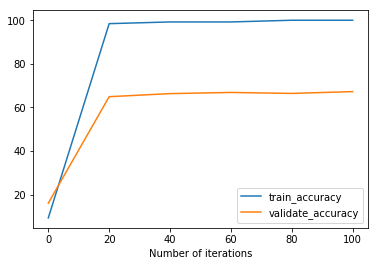

In [73]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('Extreme overfitting case with dropout')
plt.show()

For the extreme overfitting case, while the train accuracy reaches 100%, the validation and test accuracy is still low. By adding drop out, the testing accuracy increases from 66.7% to 76.5%, the generalization capability is better than the earlier one.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [129]:
def multilayer_perceptron_2h(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
 
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

beta_reg = 0.001
batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features
n_hidden_2 = 256# 2nd layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1],
                            stddev=np.sqrt(2.0 / (image_size * image_size)))),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=np.sqrt(2.0 / (n_hidden_1)))),
     'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels],
                            stddev=np.sqrt(2.0 / (n_hidden_2)))),
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_2h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
    beta_reg *tf.nn.l2_loss(weights['out']) +
    beta_reg *tf.nn.l2_loss(weights['h1'])+
    beta_reg *tf.nn.l2_loss(weights['h2']))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_2h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_2h(tf_test_dataset, weights, biases))

In [130]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.624664
Minibatch accuracy: 10.9%
Validation accuracy: 16.9%
Minibatch loss at step 500: 1.986945
Minibatch accuracy: 89.8%
Validation accuracy: 83.6%
Minibatch loss at step 1000: 1.567806
Minibatch accuracy: 82.8%
Validation accuracy: 84.0%
Minibatch loss at step 1500: 0.950352
Minibatch accuracy: 92.2%
Validation accuracy: 86.0%
Minibatch loss at step 2000: 0.743068
Minibatch accuracy: 91.4%
Validation accuracy: 86.4%
Minibatch loss at step 2500: 0.689173
Minibatch accuracy: 89.1%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 0.674943
Minibatch accuracy: 85.2%
Validation accuracy: 87.1%
Minibatch loss at step 3500: 0.617003
Minibatch accuracy: 85.9%
Validation accuracy: 87.0%
Minibatch loss at step 4000: 0.527238
Minibatch accuracy: 91.4%
Validation accuracy: 87.2%
Minibatch loss at step 4500: 0.461799
Minibatch accuracy: 89.1%
Validation accuracy: 87.0%
Minibatch loss at step 5000: 0.524014
Minibatch accuracy: 88.3%
Validation accurac

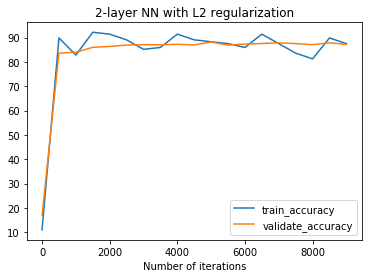

In [131]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('2-layer NN with L2 regularization')
plt.show()

In [132]:
beta_reg = 0.001
batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features
n_hidden_2 = 256# 2nd layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1],
                            stddev=np.sqrt(2.0 / (image_size * image_size)))),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=np.sqrt(2.0 / (n_hidden_1)))),
     'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels],
                            stddev=np.sqrt(2.0 / (n_hidden_2)))),
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_2h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
    beta_reg *tf.nn.l2_loss(weights['out']) +
    beta_reg *tf.nn.l2_loss(weights['h1'])+
    beta_reg *tf.nn.l2_loss(weights['h2']))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_2h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_2h(tf_test_dataset, weights, biases))

In [133]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.905868
Minibatch accuracy: 7.0%
Validation accuracy: 16.1%
Minibatch loss at step 500: 1.585421
Minibatch accuracy: 89.8%
Validation accuracy: 84.5%
Minibatch loss at step 1000: 1.285354
Minibatch accuracy: 85.2%
Validation accuracy: 85.6%
Minibatch loss at step 1500: 0.861115
Minibatch accuracy: 91.4%
Validation accuracy: 86.9%
Minibatch loss at step 2000: 0.762338
Minibatch accuracy: 91.4%
Validation accuracy: 87.3%
Minibatch loss at step 2500: 0.728893
Minibatch accuracy: 89.1%
Validation accuracy: 87.9%
Minibatch loss at step 3000: 0.755258
Minibatch accuracy: 85.2%
Validation accuracy: 87.6%
Minibatch loss at step 3500: 0.725535
Minibatch accuracy: 86.7%
Validation accuracy: 88.2%
Minibatch loss at step 4000: 0.588918
Minibatch accuracy: 91.4%
Validation accuracy: 88.3%
Minibatch loss at step 4500: 0.551985
Minibatch accuracy: 89.8%
Validation accuracy: 88.6%
Minibatch loss at step 5000: 0.621557
Minibatch accuracy: 91.4%
Validation accuracy

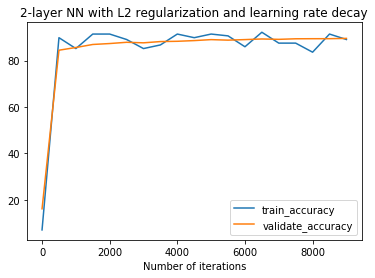

In [134]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('2-layer NN with L2 regularization and learning rate decay')
plt.show()

By decaying the learning rate, the test accuracy for the 2-layer NN increases from 93% to  95.2%

In [141]:
def multilayer_perceptron_3h(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Hidden layer with RELU activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
 
    # Output layer with linear activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer



In [145]:
beta_reg = 0.001
batch_size = 128
n_hidden_1 = 1024 # 1st layer number of features
n_hidden_2 = 256# 2nd layer number of features
n_hidden_3 = 128# 3rd layer number of features

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1],
                            stddev=np.sqrt(2.0 / (image_size * image_size)))),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],
                            stddev=np.sqrt(2.0 / (n_hidden_1)))),
     'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],
                            stddev=np.sqrt(2.0 / (n_hidden_2)))),
     'out': tf.Variable(tf.random_normal([n_hidden_3, num_labels],
                            stddev=np.sqrt(2.0 / (n_hidden_3)))),
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'b3': tf.Variable(tf.random_normal([n_hidden_3])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }

  # Training computation.
  logits = multilayer_perceptron_3h(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
    beta_reg *tf.nn.l2_loss(weights['out']) +
    beta_reg *tf.nn.l2_loss(weights['h1'])+
    beta_reg *tf.nn.l2_loss(weights['h2'])+
    beta_reg *tf.nn.l2_loss(weights['h3']))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(multilayer_perceptron_3h(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(multilayer_perceptron_3h(tf_test_dataset, weights, biases))

In [146]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  steps = []
  train_history = []
  valid_history = []
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      train_accuracy = accuracy(predictions, batch_labels)
      valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
      steps.append(step)
      train_history.append(train_accuracy)
      valid_history.append(valid_accuracy)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % train_accuracy)
      print("Validation accuracy: %.1f%%" % valid_accuracy)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5.588408
Minibatch accuracy: 12.5%
Validation accuracy: 10.0%
Minibatch loss at step 1000: nan
Minibatch accuracy: 8.6%
Validation accuracy: 10.0%


KeyboardInterrupt: 

In [ ]:
plt.plot(steps,train_history)
plt.plot(steps,valid_history)
plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
plt.xlabel('Number of iterations')
plt.title('3-layer NN with L2 regularization and learning rate decay')
plt.show()